# Interpolating Time Series Data in Apache Spark and Python Pandas - Part 2: PySpark

This is the second out of two posts about interpolating time series data using PySpark and Python Pandas. Last week, we have 
covered how to use three different interpolation methods (forward filling, backward filling, interpolation) in Pandas,
this week, we cover how we can implement the same functionality in PySpark. Note that this notebook is not necessarily executable as is. The PySpark code just demonstrates how you would do the task in PySpark and can be copied and pasted into your environment.

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

## Preparing the Data and Visualization of the Problem

We follow the same procedure as least week to generate a data set with missing values to interpolate. First we generate a pandas data frame with some test data. The data set contains data for two houses and uses a $sin$ and a $cos$ function to generate some read data for a set of dates. To generate the missing values, we randomly drop half of the entries.

In [3]:
data = {'readtime': pd.date_range(start='1/15/2018', end='02/14/2018', freq='D')\
                .append(pd.date_range(start='1/15/2018', end='02/14/2018', freq='D')),
        'house' : ['house1' for i in range(31)] + ['house2' for i in range(31)],
        'readvalue': [0.5+0.5*np.sin(2*np.pi/30*i) for i in range(31)]\
                + [0.5+0.5*np.cos(2*np.pi/30*i) for i in range(31)]}
df0 = pd.DataFrame(data, columns = ['readtime', 'house', 'readvalue'])

random.seed(42)
df0 = df0.drop(random.sample(range(df0.shape[0]), k=int(df0.shape[0]/2)))
df0.head()

,readtime,house,readvalue
0,2018-01-15,house1,0.500000
3,2018-01-18,house1,0.793893
4,2018-01-19,house1,0.871572
9,2018-01-24,house1,0.975528
10,2018-01-25,house1,0.933013


The following graph shows the data with the missing values clearly visible.

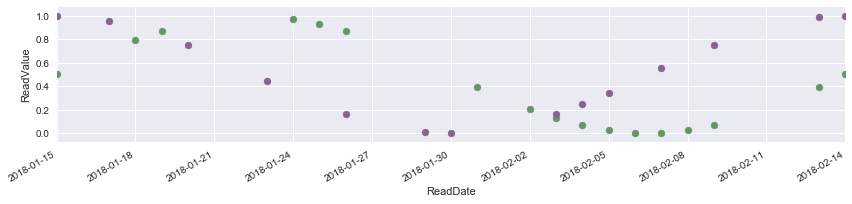

In [9]:
# Generating a plot of the data with missing values

# Setting figure size
plt.rcParams["figure.figsize"] = (12,3)

# Generate colors using nices seaborn color palette
colors = {"house1": sns.color_palette("Set1", n_colors=8, desat=.5)[2],\
          "house2": sns.color_palette("Set1", n_colors=8, desat=.5)[3]}

fig, ax = plt.subplots()

for myhouse in ["house1", "house2"]:
    ax.scatter(pd.DatetimeIndex(df0[df0.house==myhouse]['readtime']),\
               df0[df0.house==myhouse]['readvalue'],\
               color=colors[myhouse])

ax.set_xlabel("ReadDate")
ax.set_ylabel("ReadValue")

# Format x-axis to properly displays dates
fig.autofmt_xdate()
ax.set_xlim(min(pd.DatetimeIndex(df0['readtime'])), max(pd.DatetimeIndex(df0['readtime'])))

plt.tight_layout()
plt.show()

In order to work with PySpark, we convert the Pandas data frame into a Spark data frame. We need to divide the datetime by 10^9 since the unit of time is different for pandas datetime and spark. We also add the column 'readtime_existent' to keep track of which values are missing and which are not.

In [ ]:
import pyspark.sql.functions as func
from pyspark.sql.functions import col

df = spark.createDataFrame(df0)
df = df.withColumn("readtime", col('readtime')/1e9)\
        .withColumn("readtime_existent", col("readtime"))
df.show(3)

+-----------+------+------------------+-----------------+
|   readtime| house|         readvalue|readtime_existent|
+-----------+------+------------------+-----------------+
|1.5159744E9|house1|               0.5|      1.5159744E9|
|1.5162336E9|house1|0.7938926261462366|      1.5162336E9|
|  1.51632E9|house1| 0.871572412738697|        1.51632E9|
+-----------+------+------------------+-----------------+

## Interpolation
### Resampling the Read Datetime

As in Pandas, the first step is to resample the time data. However, unfortunately Spark does not provide an equivalent to Pandas *resample()* method. Our workaround is generating an array containing an equally spaced time grid between the mininmum and maximum time. The trick here is to first group the read data by house, then create the respective array for each house and use the sql function *explode()* to convert the array into a column. The resulting structure is then used as basis to which we add the read value information for the times where it exists using a left outer join. The following code shows how this is done. 

In [ ]:
from pyspark.sql.types import *

# define function to create date range
def date_range(t1, t2, step=60*60*24):
    """Returns a list of equally spaced points between t1 and t2 with stepsize step."""
    return [t1 + step*x for x in range(int((t2-t1)/step)+1)]

# define udf
date_range_udf = func.udf(date_range, ArrayType(LongType()))

# group data by house, obtain min and max time by house, create time arrays and explode them
df_base = \
    df.groupBy('house')\
        .agg(func.min('readtime').cast('integer').alias('readtime_min'), func.max('readtime').cast('integer').alias('readtime_max'))\
        .withColumn("readtime", func.explode(date_range_udf("readtime_min", "readtime_max")))\
        .drop('readtime_min', 'readtime_max')

# left outer join existing read values
df_all_dates = df_base.join(df, ["house", "readtime"], "leftouter")

The resulting table looks like this:

+------+----------+--------------------+-----------------+
| house|  readtime|           readvalue|readtime_existent|
+------+----------+--------------------+-----------------+
|house2|1516924800| 0.16543469682057105|      1.5169248E9|
|house2|1516060800|                null|             null|
|house2|1516665600| 0.44773576836617335|      1.5166656E9|
|house1|1517184000|                null|             null|
|house1|1517961600|0.002739052315863...|      1.5179616E9|
+------+----------+--------------------+-----------------+

### Forward-fill and Backward-fill Using Window Functions
When using a forward-fill, we fill-in the missing data with the latest known value before now. In contrast, when using a backwards-fill, we fill-in the data with the next known value. This idea of looking at a subset of data is well known and used in SQL and can be implemented using the *pyspark.sql.Window* function in combination with *last()* and *first()*. The crucial part in both cases is to use the *ignorenulls=True* argument. On the partitioned and sorted data, we look for:

* forward-fill: the last not-null value in the window ranging from minus infinity to now
* backward-fill: the first not-null value in the window ranging from now to plus infinity

Here is how to create the interpolated columns and add them to the data frame. We also keep the interpolated read times since we will need them for the interpolation.

In [ ]:
from pyspark.sql import Window
import sys

window_ff = Window.partitionBy('house')\
               .orderBy('readtime')\
               .rowsBetween(-sys.maxsize, 0)
               
window_bf = Window.partitionBy('house')\
               .orderBy('readtime')\
               .rowsBetween(0, sys.maxsize)
        
# create the series containing the filled values
read_last = func.last(df_all_dates['readvalue'], ignorenulls=True).over(window_ff)
readtime_last = func.last(df_all_dates['readtime_existent'], ignorenulls=True).over(window_ff)

read_next = func.first(df_all_dates['readvalue'], ignorenulls=True).over(window_bf)
readtime_next = func.first(df_all_dates['readtime_existent'], ignorenulls=True).over(window_bf)

# add the columns to the dataframe
df_filled = df_all_dates.withColumn('readvalue_ff', read_last)\
                        .withColumn('readtime_ff', readtime_last)\
                        .withColumn('readvalue_bf', read_next)\
                        .withColumn('readtime_bf', readtime_next)

### Interpolation

Finally we use the forward filled and backwards filled data to interpolate both read datetimes and read values using a simple spline. This can be done using a user-defined function.

In [ ]:
# define interpolation function
def interpol(x, x_prev, x_next, y_prev, y_next, y):
    if x_prev == x_next:
        return y
    else:
        m = (y_next-y_prev)/(x_next-x_prev)
        y_interpol = y_prev + m * (x - x_prev)
        return y_interpol

# convert function to udf
interpol_udf = func.udf(interpol, FloatType())   
    
# add interpolated columns to dataframe and clean up
df_filled = df_filled.withColumn('readvalue_interpol', interpol_udf('readtime', 'readtime_ff', 'readtime_bf', 'readvalue_ff', 'readvalue_bf', 'readvalue'))\
                    .drop('readtime_existent', 'readtime_ff', 'readtime_bf')\
                    .withColumnRenamed('reads_all', 'readvalue')\
                    .withColumn('readtime', func.from_unixtime(col('readtime')))

This leaves us with a single dataframe containing all of the interpolation methods. This is how its structure looks like:

+------+-------------------+------------------+------------------+------------------+------------------+
| house|           readtime|         readvalue|      readvalue_ff|      readvalue_bf|readvalue_interpol|
+------+-------------------+------------------+------------------+------------------+------------------+
|house1|2018-01-15 00:00:00|               0.5|               0.5|               0.5|               0.5|
|house1|2018-01-16 00:00:00|              null|               0.5|0.7938926261462366|         0.5979642|
|house1|2018-01-17 00:00:00|              null|               0.5|0.7938926261462366|         0.6959284|
|house1|2018-01-18 00:00:00|0.7938926261462366|0.7938926261462366|0.7938926261462366|         0.7938926|
|house1|2018-01-19 00:00:00| 0.871572412738697| 0.871572412738697| 0.871572412738697|        0.87157243|
+------+-------------------+------------------+------------------+------------------+------------------+

Finally we can visualize the results to observe the differences between the interpolation techniques. The opaque dots show the interpolated values.

We can clearly see how in the top figure, the gaps have been filled with the last known value, in the middle figure, the gaps have been filled with the next value to come and in the bottom figure the difference has been interpolated.

In [ ]:
df_pd = df_filled.sort('house', 'readtime').toPandas()

plt.rcParams["figure.figsize"] = (12,6)

# Generate colors using nices seaborn color palette
colors = {"house1": sns.color_palette("Set1", n_colors=8, desat=.5)[2],\
          "house2": sns.color_palette("Set1", n_colors=8, desat=.5)[3]}

dfs = []
dfs.append(df_pd[['house', 'readtime', 'readvalue_ff']].rename(index=str, columns={"readtime":"datetime", "readvalue_ff":"readvalue"}).reset_index())
dfs.append(df_pd[['house', 'readtime', 'readvalue_bf']].rename(index=str, columns={"readtime":"datetime", "readvalue_bf":"readvalue"}).reset_index())
dfs.append(df_pd[['house', 'readtime', 'readvalue_interpol']].rename(index=str, columns={"readtime":"datetime", "readvalue_interpol":"readvalue"}).reset_index())

ylabel = ['pad', 'bfill', 'interpolate']

n_df = len(dfs)
fig, ax = plt.subplots(n_df)

for myhouse in ["house1", "house2"]:
    for i in range(n_df):
        ax[i].scatter(pd.DatetimeIndex(dfs[i][dfs[i].house==myhouse]['datetime']), pd.to_numeric(dfs[i][dfs[i].house==myhouse]['readvalue']), color=colors[myhouse], alpha=0.5)
        ax[i].scatter(pd.DatetimeIndex(df0[df0.house==myhouse]['readtime']), pd.to_numeric(df0[df0.house==myhouse]['readvalue']), color=colors[myhouse])        
        ax[i].set_xlim(min(pd.DatetimeIndex(df0['readtime'])), max(pd.DatetimeIndex(df0['readtime'])))

fig.autofmt_xdate()

for i in range(n_df):
    ax[i].set_ylabel(ylabel[i])

# Adding another subplot in order to have common y-label
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the common axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('ReadDate', labelpad=40)
plt.ylabel('ReadValue', labelpad=40)

plt.show()
plt.close()